In [1]:
# # prompt: get the drive connected to the notebook

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
!pip install torch torch_geometric transformers


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


In [6]:
import os
import json
import torch
from torch_geometric.data import Data

def preprocess_object(obj, tokenizer=tokenizer, device=device):
    # Extract graph data
    vertices = torch.tensor(obj['v'], dtype=torch.float).to(device)  # Move to device
    edges = torch.tensor(obj['e'], dtype=torch.long).t().to(device)  # Transpose and move to device

    # Encode text label using BERT
    text_label_str = obj['n']
    inputs = tokenizer(text_label_str, return_tensors="pt", padding=True, truncation=True, max_length=32)
    input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

    with torch.no_grad():
        outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
    text_label_embedding = outputs.last_hidden_state.to(device)  # Pool the embeddings and move to device
    print(text_label_embedding.shape)
    pooled_text_label = text_label_embedding.mean(dim=1)
    # Create graph data
    graph_data = Data(x=vertices, edge_index=edges, text_label=pooled_text_label)
    
    print(graph_data)
    return graph_data

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

        return preprocess_object(data)

def create_dataset(folder_path):
    dataset = []
    file_list = os.listdir(folder_path)
    print(len(file_list))
    for file_name in file_list:
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            data = load_json(file_path)
            dataset.append(data)
            print(file_name)
    return dataset

In [7]:
# Dataset and DataLoader
def load_data_and_split(folder_path, ):
    dataset = create_dataset(folder_path)
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = load_data_and_split('./json')

57
torch.Size([1, 5, 768])
Data(x=[3160, 3], edge_index=[2, 5983], text_label=[1, 768])
AR_1.json
torch.Size([1, 5, 768])
Data(x=[3011, 3], edge_index=[2, 6472], text_label=[1, 768])
AR_2.json
torch.Size([1, 7, 768])
Data(x=[288, 3], edge_index=[2, 550], text_label=[1, 768])
AR_3.json
torch.Size([1, 3, 768])
Data(x=[232, 3], edge_index=[2, 448], text_label=[1, 768])
AR_4.json
torch.Size([1, 5, 768])
Data(x=[1997, 3], edge_index=[2, 4171], text_label=[1, 768])
AR_5.json
torch.Size([1, 5, 768])
Data(x=[3171, 3], edge_index=[2, 7212], text_label=[1, 768])
AR_6.json
torch.Size([1, 8, 768])
Data(x=[1017, 3], edge_index=[2, 1909], text_label=[1, 768])
AssaultRifle2_1.json
torch.Size([1, 8, 768])
Data(x=[995, 3], edge_index=[2, 1753], text_label=[1, 768])
AssaultRifle2_2.json
torch.Size([1, 8, 768])
Data(x=[858, 3], edge_index=[2, 1612], text_label=[1, 768])
AssaultRifle2_3.json
torch.Size([1, 8, 768])
Data(x=[747, 3], edge_index=[2, 1355], text_label=[1, 768])
AssaultRifle2_4.json
torch.Size

Vertices: [[-0.0984 -0.0277 -0.1517]
 [-0.0984 -0.0277 -0.1517]
 [-0.2051 -0.0077 -0.1048]
 ...
 [ 0.8377  0.1737  0.1799]
 [ 0.8967  0.173   0.2041]
 [ 0.8967  0.173   0.2041]]
Edges: [[  16   16   16 ... 3631 3639 3631]
 [  31   48   17 ... 3643 3648 3650]]
Text: [[ 2.05202490e-01  1.13316355e-02 -3.47233228e-02  8.72488040e-03
  -1.69622973e-01 -1.09592259e-01  2.45473474e-01 -2.59881645e-01
  -1.95649713e-01 -1.87684357e-01 -7.14337546e-03 -2.03294232e-01
  -2.08232954e-01  1.28734082e-01  4.36373940e-03  1.67139888e-01
  -2.50757754e-01  9.49261803e-03  4.02146056e-02  2.01254375e-02
   3.35501969e-01 -1.37745351e-01  3.38111490e-01 -1.58095449e-01
   2.53114283e-01  1.67773560e-01 -9.53679383e-02  2.38252133e-01
  -2.13909581e-01 -4.84291539e-02 -4.66605835e-02 -1.87639326e-01
   3.59785199e-01  2.02996343e-01 -1.53695971e-01 -1.72216967e-02
  -3.60560417e-01 -3.08593690e-01 -2.42958758e-02  1.53670892e-01
  -2.56325416e-02 -4.03037399e-01 -1.33823305e-01  2.45173484e-01
  -4.420

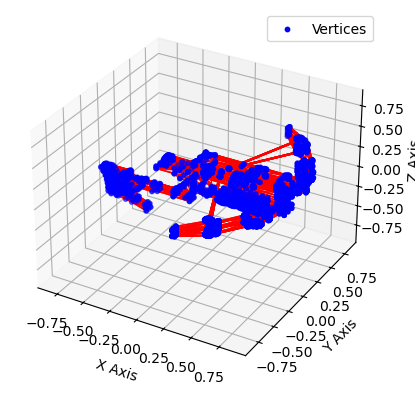

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize the 3D graph
def visualize_3d(vertices, edges):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure vertices are a numpy array
    vertices = np.array(vertices)

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]  # Each column represents an edge (start_index, end_index)
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]], c='r', linewidth=1)

    # Set plot labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    # Set equal scaling for all axes
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Display the plot
    plt.show()

# Extract vertices and edges from the dataset
vertices_np, edges_np, text_label = train_dataset[1].x.cpu().numpy(), train_dataset[1].edge_index.cpu().numpy(),train_dataset[1].text_label.cpu().numpy()

# Print the first graph's data for verification
print("Vertices:", vertices_np)
print("Edges:", edges_np)
print("Text:", text_label)

# Visualize the first graph
visualize_3d(vertices_np, edges_np)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# Transformer Encoder
class TransformerTextEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        """
        Args:
            embed_dim: Embedding dimension of the input (e.g., 768 for BERT-base).
            num_heads: Number of attention heads in the Transformer.
            num_layers: Number of Transformer encoder layers.
        """
        super(TransformerTextEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )

    def forward(self, text_input):
        """
        Args:
            text_input: Tensor of shape [batch_size, sequence_length, embed_dim]
        
        Returns:
            c_text: Latent feature of shape [batch_size, embed_dim]
        """
        if text_input.dim() != 3:
            raise ValueError(
                f"Expected text_input to have 3 dimensions (batch_size, sequence_length, embed_dim), "
                f"but got {text_input.dim()} dimensions."
            )
        
        # Transpose to [sequence_length, batch_size, embed_dim] for Transformer
        # Pass through Transformer encoder
        encoded_text = self.transformer(text_input)  # Shape: [sequence_length, batch_size, embed_dim]
        
        # Pooling: Average over the sequence dimension
        c_text = encoded_text.mean(dim=0)  # Shape: [batch_size, embed_dim]
        
        return c_text

# Graph Encoder (GNN)
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        return x.mean(dim=0)  # Pooling to get latent feature z_G

# Feature Fusion
class FeatureFusion(nn.Module):
    def __init__(self, text_dim, graph_dim, fused_dim):
        super(FeatureFusion, self).__init__()
        self.fc = nn.Linear(text_dim + graph_dim, fused_dim)

    def forward(self, c_text, z_G):

        if c_text.ndim == 2 and z_G.ndim == 1:
            z_G = z_G.unsqueeze(0).expand(c_text.size(0), -1)

        combined_features = torch.cat([c_text, z_G], dim=-1)
        fused_features = self.fc(combined_features)
        return fused_features

# Vector Quantization (VQ)
class VectorQuantization(nn.Module):
    def __init__(self, codebook_size, embedding_dim):
        super(VectorQuantization, self).__init__()
        self.codebook = nn.Embedding(codebook_size, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

    def forward(self, z):
        z_flattened = z.view(-1, z.size(-1))
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     - 2 * torch.matmul(z_flattened, self.codebook.weight.T)
                     + torch.sum(self.codebook.weight**2, dim=1))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(encoding_indices).view(z.shape)
        return z_q, encoding_indices

# Graph Decoder
class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, node_dim):
        """
        Args:
            latent_dim: Dimension of the latent embeddings for nodes.
            node_dim: Dimension of the output node features.
        """
        super(GraphDecoder, self).__init__()
        self.node_decoder = nn.Linear(latent_dim, node_dim)  # Node feature decoder
        self.edge_mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1)  # Predict edge weights
        )

    def forward(self, z, edge_index=None):
        """
        Args:
            z: Node latent embeddings of shape [num_nodes, latent_dim].
            edge_index: Edge indices of shape [2, num_edges]. Optional during generation.

        Returns:
            reconstructed_nodes: Reconstructed node features of shape [num_nodes, node_dim].
            reconstructed_edges: Reconstructed edge weights of shape [num_edges] (if edge_index is provided).
            adjacency_matrix: Optional, dense adjacency matrix during generation.
        """
        # Decode node features
        reconstructed_nodes = self.node_decoder(z)  # [num_nodes, node_dim]

        if edge_index is not None:
            # Training: Use edge_index to predict edge weights
            z_src = z[edge_index[0]]  # Source node embeddings [num_edges, latent_dim]
            z_tgt = z[edge_index[1]]  # Target node embeddings [num_edges, latent_dim]
            edge_features = torch.cat([z_src, z_tgt], dim=-1)  # Concatenate for pairwise interaction
            reconstructed_edges = self.edge_mlp(edge_features).squeeze(-1)  # [num_edges]
            return reconstructed_nodes, reconstructed_edges

        else:
            # Generation: Predict a dense adjacency matrix
            num_nodes = z.size(0)
            z_expanded = z.unsqueeze(0).expand(num_nodes, -1, -1)  # [num_nodes, num_nodes, latent_dim]
            z_t_expanded = z.unsqueeze(1).expand(-1, num_nodes, -1)  # [num_nodes, num_nodes, latent_dim]
            edge_features = torch.cat([z_expanded, z_t_expanded], dim=-1)  # [num_nodes, num_nodes, 2*latent_dim]
            adjacency_matrix = self.edge_mlp(edge_features).squeeze(-1)  # [num_nodes, num_nodes]
            return reconstructed_nodes, adjacency_matrix




In [11]:
class TransformerGraphDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, vocab_size):
        super(TransformerGraphDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 100, embed_dim))  # Adjust max sequence length
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt, memory):
        """
        Args:
            tgt: Target sequence [batch_size, seq_len]
            memory: Encoded memory from the Transformer Encoder [batch_size, seq_len, embed_dim]

        Returns:
            Output logits for graph tokens [batch_size, seq_len, vocab_size]
        """
        tgt_embedded = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.decoder(tgt_embedded.transpose(0, 1), memory.transpose(0, 1), tgt_mask).transpose(0, 1)
        logits = self.fc_out(output)
        return logits

In [13]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from torch.optim import Adam

def set_mode(model, mode="train"):
    """
    Set all components of the model to train or eval mode.
    Args:
        model (dict): Dictionary of model components.
        mode (str): "train" or "eval".
    """
    for component in model.values():
        if mode == "train":
            component.train()
        elif mode == "eval":
            component.eval()

# Training Function
def train_one_epoch(model, data_loader, optimizer, device):
    set_mode(model, mode="train")
    total_loss = 0
    print("Training", len(data_loader))
    for data in data_loader:
        data = data.to(device)

        # Inputs
        text_input = data.text_label  # Use the text_label from the data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
        graph_x = data.x  # Node features
        edge_index = data.edge_index  # Edge indices

        # Forward pass
        
        c_text = model['text_encoder'](text_input.unsqueeze(1))
        z_G = model['graph_encoder'](graph_x, edge_index)
        
        
        fused_features = model['feature_fusion'](c_text, z_G)
        z_qG, _ = model['vector_quantizer'](fused_features)
        reconstructed_nodes, reconstru  cted_adj = model['graph_decoder'](z_qG)
        
        target_adj = to_dense_adj(edge_index).squeeze(0)

        # Loss: Reconstruction and Token Prediction
        loss_nodes = F.mse_loss(reconstructed_nodes, graph_x)
        loss_adj = F.mse_loss(reconstructed_adj, target_adj)  # Approximation
        loss = loss_nodes + loss_adj

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    set_mode(model, mode="eval")
    total_loss = 0

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)

            # Inputs
             # Inputs
            text_input = data.text_label  # Use the text_label from the data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            graph_x = data.x  # Node features
            edge_index = data.edge_index  # Edge indices

        # Forward pass
        
            c_text = model['text_encoder'](text_input.unsqueeze(1))
            z_G = model['graph_encoder'](graph_x, edge_index)
        
        
            fused_features = model['feature_fusion'](c_text, z_G)
            print('Features',fused_features.shape)
            z_qG, _ = model['vector_quantizer'](fused_features)
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG)
        
            target_adj = to_dense_adj(edge_index).squeeze(0)

            # Loss: Reconstruction and Token Prediction
            loss_nodes = F.mse_loss(reconstructed_nodes, graph_x)
            loss_adj = F.mse_loss(reconstructed_adj, target_adj)  
            loss = loss_nodes + loss_adj


            total_loss += loss.item()

    return total_loss / len(data_loader)



# Model components
model = {
        "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
        "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64, num_layers=3).to(device),
        "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
        "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
        "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3).to(device),
        "transformer_decoder": TransformerGraphDecoder(embed_dim=128, num_heads=4, num_layers=2, vocab_size=100).to(device)
    }
# Main Training Loop
def main_training(num_epochs=10, batch_size=4, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Optimizer
    optimizer = Adam(
        [param for part in model.values() for param in part.parameters()],
        lr=learning_rate,
    )

    # Load Data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training
main_training()


Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 1/10 - Train Loss: 0.6209, Val Loss: 0.1361
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 2/10 - Train Loss: 0.6555, Val Loss: 0.1264
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 3/10 - Train Loss: 0.4800, Val Loss: 0.1307
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 4/10 - Train Loss: 0.5424, Val Loss: 0.1527
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 5/10 - Train Loss: 0.4969, Val Loss: 0.1255
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 6/10 - Train Loss: 0.4591, Val Loss: 0.1424
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 7/10 - Train Loss: 0.4203, Val Loss: 0.1507
Training 12
Features torch.Size([1, 128])
Features torch.Size([1, 128])
Epoch 8/10 - Train Loss: 0.5872, Val Loss: 0.1844
Training 12
Features tor

In [15]:
def generate_tokenized_dataset(model, original_data_loader, device):
    """
    Generate a tokenized dataset and save it as a variable.

    Args:
        model (dict): The model containing the graph encoder, text encoder, and vector quantizer.
        original_data_loader (DataLoader): DataLoader for the original dataset.
        device (torch.device): Device to perform computation.

    Returns:
        tokenized_dataset: List of dictionaries containing graph and text tokens.
    """
    from transformers import BertTokenizer

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_dataset = []

    model['graph_encoder'].eval()
    model['text_encoder'].eval()
    model['vector_quantizer'].eval()

    with torch.no_grad():
        for data in original_data_loader:
            data = data.to(device)

            # Generate Graph Tokens
            graph_x = data.x  # Node features
            edge_index = data.edge_index  # Edge indices
            z_G = model['graph_encoder'](graph_x, edge_index)
            z_qG, _ = model['vector_quantizer'](z_G)  # Graph tokens

            # Generate Text Tokens
            text_label = data.text_label  # Text description
            inputs = tokenizer(
                text_label,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=32
            ).to(device)
            text_tokens = model['text_encoder'](inputs['input_ids'].float())  # Text tokens

            # Add to dataset
            tokenized_dataset.append({
                'graph_tokens': z_qG.cpu(),
                'text_tokens': text_tokens.cpu()
            })

    return tokenized_dataset


In [16]:
from torch.utils.data import DataLoader

# Generate the tokenized dataset
tokenized_dataset = generate_tokenized_dataset(model, train_dataset, device)

# Define a simple PyTorch DataLoader directly from the list
tokenized_data_loader = DataLoader(tokenized_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: {
    'graph_tokens': torch.stack([item['graph_tokens'] for item in x]),
    'text_tokens': torch.stack([item['text_tokens'] for item in x])
})

# Training with the DataLoader
optimizer = torch.optim.Adam(model['transformer_decoder'].parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model['transformer_decoder'].train()
    total_loss = 0

    for batch in tokenized_data_loader:
        graph_tokens = batch['graph_tokens'].to(device)
        text_tokens = batch['text_tokens'].to(device)

        # Forward pass
        logits = model['transformer_decoder'](graph_tokens[:, :-1], text_tokens)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), graph_tokens[:, 1:].contiguous().view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(tokenized_data_loader):.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x64 and 128x512)

In [112]:
torch.save({name: part.state_dict() for name, part in model.items()}, "trained_model.pth")



In [125]:
text_label_str = "AR gun"
inputs = tokenizer(text_label_str, return_tensors="pt", padding=True, truncation=True, max_length=32)
input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

with torch.no_grad():
    outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
text_label_embedding = outputs.last_hidden_state.to(device) 

In [126]:
def generate_graph_from_bert(model, bert_embedding, device):
    """
    Generate a graph using BERT embeddings and the codebook.
    
    Args:
        model: Dictionary containing the model components.
        bert_embedding: Tensor of shape [1, embedding_dim] from BERT.
        device: Device to run the model on (CPU or GPU).
    """
    # Move BERT embedding to the correct device
    bert_embedding = bert_embedding.to(device)  # Shape: [1, embedding_dim]

    # Quantize the BERT embedding
    with torch.no_grad():
        z_q, _ = model['vector_quantizer'](bert_embedding)  # Quantized representation

    # Decode the quantized embeddings to generate graph
    reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_q)
    print("Reconstructed Nodes:", reconstructed_nodes)
    print("Reconstructed Adjacency Matrix:", reconstructed_adj)

    # Visualize the generated graph
    visualize_3d(reconstructed_nodes, reconstructed_adj)

# Example Usage
generate_graph_from_bert(model, text_label_embedding, device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x768 and 128x512)

In [113]:
with torch.no_grad():
    z_latent = torch.randn(1, 128).to(device)  # Random latent vector
    new_nodes, new_adj = model['graph_decoder'](z_latent)
    print("Generated Nodes:", new_nodes)
    print("Generated Adjacency Matrix:", new_adj)

Generated Nodes: tensor([[2.7660, 0.8223, 1.3682]])
Generated Adjacency Matrix: tensor([[-0.7473]])
